## Example for statistical downscaling in a cross-validation approach

Empirical-statistical downscaling methods under the **Perfect Prognosis approach** are first trained using reanalysis data (predictors) and observations (predictands) and subsequently applied to GCM predictors to produce climate change local projections. It is essential to pay attention to the calibration/training phase, try different methods' configurations and predictor variables and evaluate the calibrated methods properly before they are applied to GCM data. 

In this notebook, we use predictors from reanalysis for the **calibration and testing** to avoid introducing other error sources in the predictions (e.g. GCM biases). Reanalysis data guarantee day-to-day correspondence with observations, which does not hold for model data. A **k-fold cross-validation** is used in order to ensure independent data for calibrating and validating the methods. The best method configuration as well as the best predictor set, will be then used to develop local climate change projections using GCM data (see `script03_downscaling_GCM.ipynb`).

### Setup and configuration

We first load the required libraries:

In [1]:
rm(list=ls())
library(loadeR) # part of climate4R:  load data
library(transformeR) # part of climate4R:  data manipulation and analysis
library(downscaleR) # part of climate4R: downscaling and bias correction
library(visualizeR) # part of climate4R: visualization
library(lattice) # to use some functionalities of spplot directly
library(sp) 
library(RColorBrewer) # color themes

Loading required package: rJava

Loading required package: loadeR.java

Java version 23x amd64 by N/A detected

The maximum JVM heap space available is: 2.00 GB

NetCDF Java Library Version: 4.6.0-SNAPSHOT (Built-On: 20150423.1338) loaded and ready

You can manually set the NetCDF Java Library version before loading the package:
options(loadeR.java_forced_version = "X.Y.Z")
library(loadeR.java)

netCDF-Java CLASSPATH from bundled java package directory: /home/ana/micromamba/envs/prosecco/lib/R/library/loadeR.java/java:/home/ana/micromamba/envs/prosecco/lib/R/library/loadeR.java/java/netcdfAll-4.6.0-SNAPSHOT.jar

Loading required package: climate4R.UDG

climate4R.UDG version 0.2.6 (2023-06-26) is loaded

Please use 'citation("climate4R.UDG")' to cite this package.

loadeR version 1.8.4 (2025-08-07) is loaded

Please use 'citation("loadeR")' to cite this package.




    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.2.2 (2023-10-26) is loaded


Get the latest stable version (2.2.5) using <devtools::install_github('SantanderMetGroup/transformeR')>

Please see 'citation("transformeR")' to cite this package.

downscaleR version 3.3.4 (2023-06-22) is loaded

Please use 'citation("downscaleR")' to cite this package.

visualizeR version 1.6.4 (2023-10-26) is loaded

Please see 'citation("visualizeR")' to cite this package.



Set the working directory, where some already prepared data can be found:

In [2]:
work.dir <- "/home/jovyan/data/"
work.dir <- "/home/ana/WORK_local/DATA/Prosecco/data4notebooks/"

The next code is needed to plot maps with Italian provinces:

In [3]:
# provinces polygon
sh <- readRDS(paste0(work.dir,"italy_admin.rds")) # read shape file
proj4string(sh) = CRS("+init=epsg:4326")
sh = as(sh, "SpatialPolygons")

# plot limits
lats <- c(45.45,46.15)
lons <- c(11.7,12.8)

Warning message in `proj4string<-`(`*tmp*`, value = new("CRS", projargs = "+init=epsg:4326")):
“A new CRS was assigned to an object with an existing CRS:
+proj=longlat +datum=WGS84 +no_defs
without reprojecting.
For reprojection, use function spTransform”


### Load predictands

The predictands are **observed values** of temperature, precipitation and humidity in northeastern Italy. Data were originally subdaily (hourly or 3-hourly depending on the meteorological station). They were processed to daily values (required by downscaling) and only stations with enough data were kept. The final predictands are daily maximum, mean and minimum temperature, daily accumulated precipitation and daily mean relative humidity. The following file has the ready-to-use data for stations with less than 34\% of missing data per variable (i.e. 10 out of the 30 years).

In [4]:
load(paste0(work.dir,"/observations_subset_1991-2020.Rdata"))

The `climatology` function from  `transformeR` package allows to make temporal aggregations (temporal mean, by default). Here we use `spatialPlot` from `visualizeR` package to represent mean climatological values of observed daily maximum temperature.

[2026-02-24 16:51:07.088165] - Computing climatology...

[2026-02-24 16:51:07.09603] - Done.



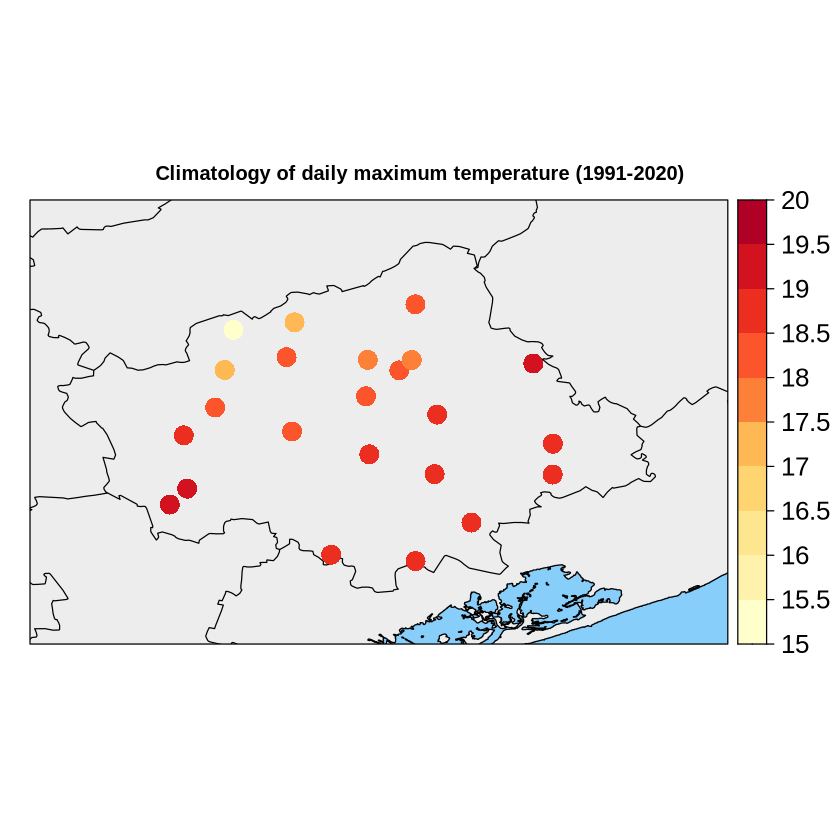

In [5]:
bk <-  seq(15,20,0.5)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(8,"YlOrRd"))
cmap <- cols(cmap.nbins)
spatialPlot(climatology(tasmax_obs), cex=2, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk),
    cuts = bk, main = list(label="Climatology of daily maximum temperature (1991-2020)", cex=1),
    par.strip.text = list(cex = 1),
    colorkey = list(right = list(fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

Likewise, this can be done for any other predictand, only changing the variable of interest and other aesthetics like colorbar or color breaks. Here, climatological conditions for relative humidity is represented:

[2026-02-24 16:51:07.927723] - Computing climatology...

[2026-02-24 16:51:07.938059] - Done.



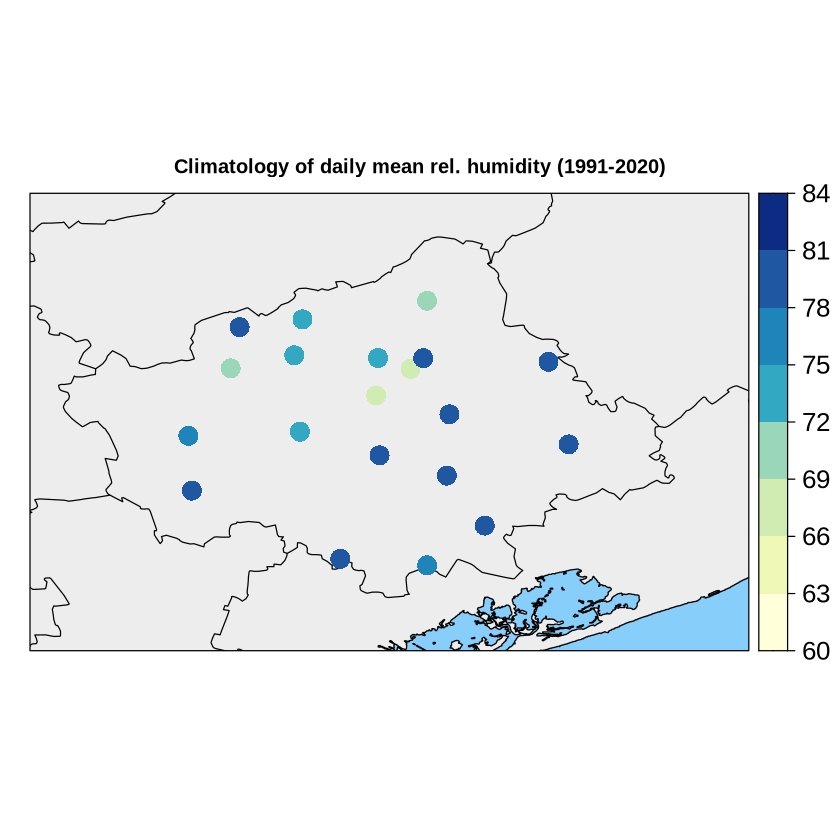

In [6]:
bk <-  seq(60,84,3)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(8,"YlGnBu"))
cmap <- cols(cmap.nbins)
spatialPlot(climatology(hurs_obs), cex=2, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk),
    cuts = bk,  main = list(label="Climatology of daily mean rel. humidity (1991-2020)", cex=1),
    par.strip.text = list(cex = 1),
    colorkey = list(right = list( fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

### Load predictors

The traning/calibration phase of statistical downscaling under Perfect Prognossis approach always involves **reanalysis data**, since it has temporal correspondence with observations. Typical predictor variables are large-scale variables (temperature, geopotential, humidity, winds) at several vertical levels. As reanalysis dataset we use [**ECMWF ERA5 reanalysis**](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview) which is provided by Copernicus.

Here we use ERA5 data already downloaded and upscaled to a 2º grid (original resolution is 0.25º, approximately 25km). Upscaling predictors is a common practice in statistical downsclaing, in order to make GCM (typically hundreds of kilometers) and reanalysis predictors more similar. For more details in the predictors' variables check `script01_retrieve_GCMdata.ipynb`, which includes a table with the variables considered and shows how to get them from GCMs.

In [7]:
load(paste0(work.dir,"/ERA5_P8predictors_2deg_1991-2020.Rdata"))

The following code checks the variables loaded and their units:

In [8]:
getVarNames(x)
attr(x$Variable, "units")

[1] "u@500" "u@700" "u@850" "v@500" "v@700" "v@850" "z@500" "z@850" "t@500"
[10] "t@700" "t@850" "q@500" "q@850" "t2m"

[1] "m s**-1"    "m s**-1"    "m s**-1"    "m s**-1"    "m s**-1"   
 [6] "m s**-1"    "m**2 s**-2" "m**2 s**-2" "K"          "K"         
[11] "K"          "kg kg**-1"  "kg kg**-1"  "K"

`climatology` allows to aggregate temporarily (mean, by default). Here we represent the mean climatological conditions of all predictor variables at the different vertical levels considered.

[2026-02-24 16:51:08.686267] - Computing climatology...

[2026-02-24 16:51:08.830241] - Done.



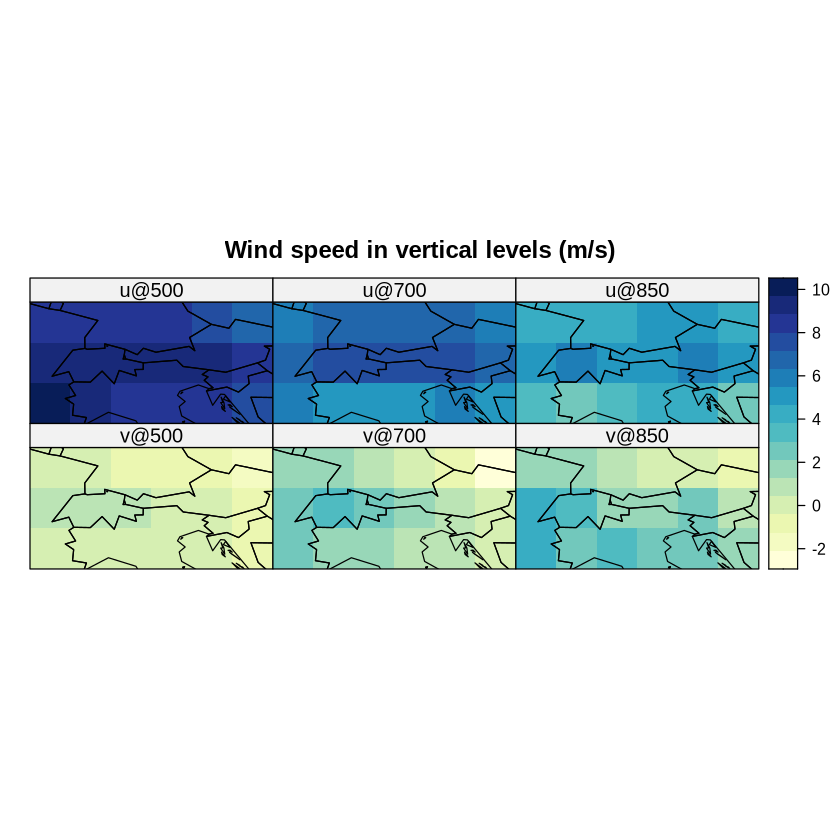

In [9]:
x_clim <- climatology(x)
spatialPlot(bindGrid(subsetGrid(x_clim, var= "u@500"), subsetGrid(x_clim, var= "u@700"), subsetGrid(x_clim, var= "u@850"), 
    subsetGrid(x_clim, var= "v@500"), subsetGrid(x_clim, var= "v@700"), subsetGrid(x_clim, var= "v@850")), 
    backdrop.theme = "countries", as.table=TRUE, names.attr=getVarNames(x)[1:6], layout= c(3,2), color.theme = "YlGnBu",
    main= "Wind speed in vertical levels (m/s)")

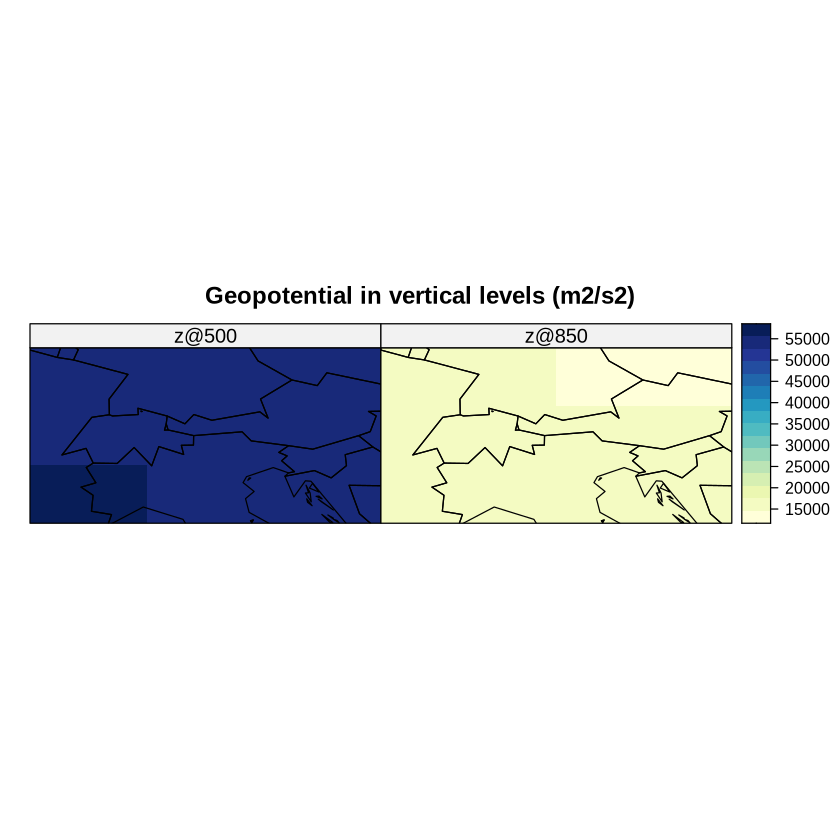

In [10]:
spatialPlot(bindGrid(subsetGrid(x_clim, var= "z@500"), subsetGrid(x_clim, var= "z@850")), 
    backdrop.theme = "countries", as.table=TRUE, names.attr=getVarNames(x)[7:8], layout= c(2,1), color.theme = "YlGnBu",
    main= "Geopotential in vertical levels (m2/s2)")

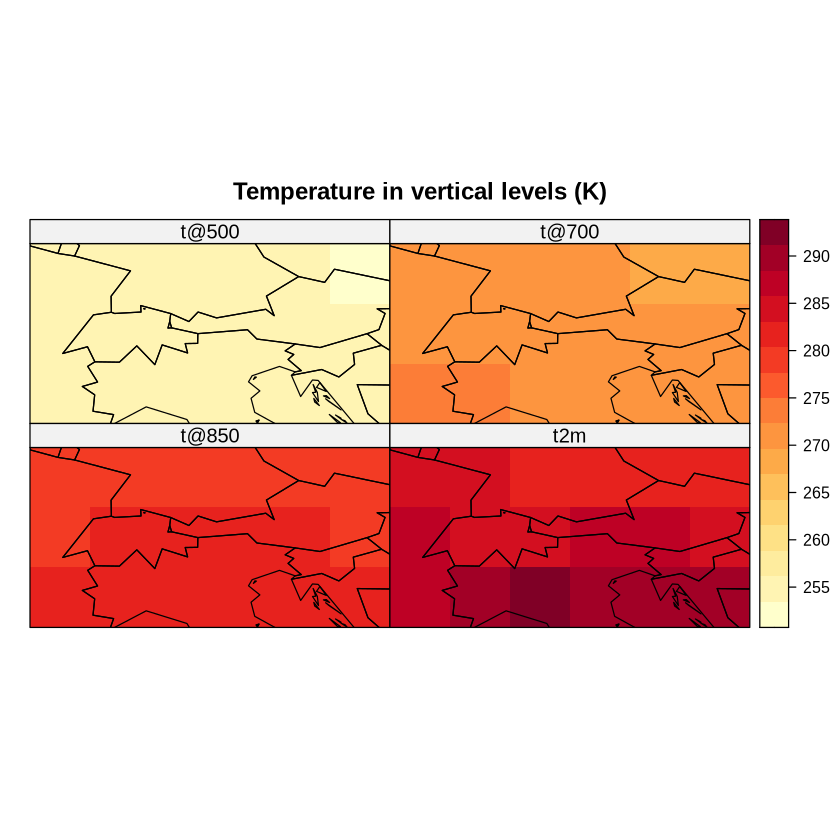

In [11]:
spatialPlot(bindGrid(subsetGrid(x_clim, var= "t@500"), subsetGrid(x_clim, var= "t@700"), subsetGrid(x_clim, var= "t@850"), subsetGrid(x_clim, var= "t2m")), 
    backdrop.theme = "countries", as.table=TRUE, names.attr=c(getVarNames(x)[9:11],"t2m"), layout= c(2,2), color.theme = "YlOrRd",
    main= "Temperature in vertical levels (K)")

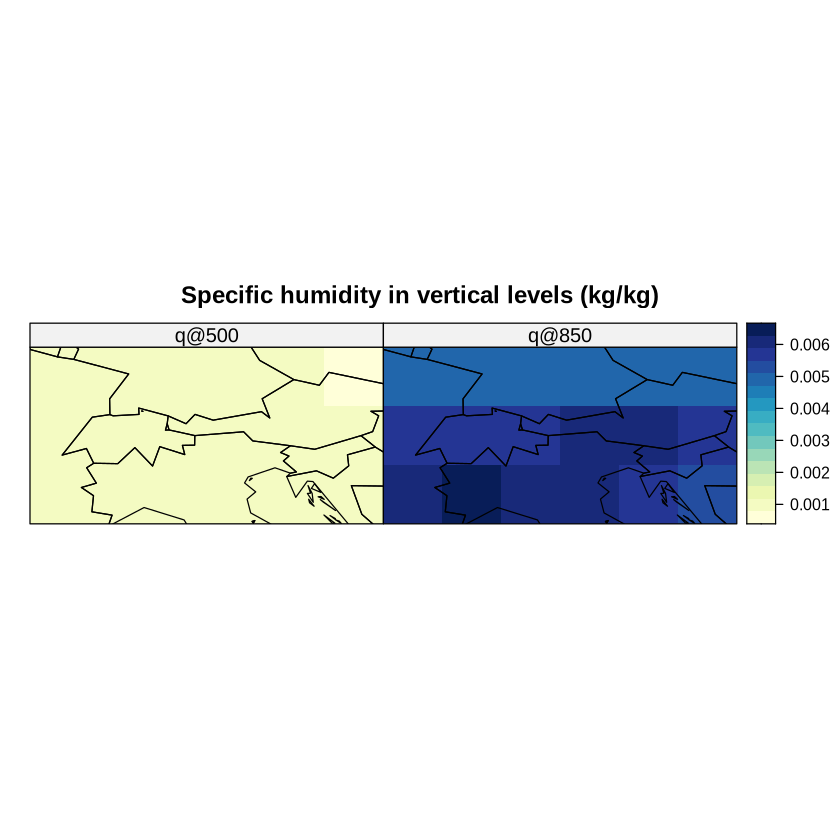

In [12]:
spatialPlot(bindGrid(subsetGrid(x_clim, var= "q@500"), subsetGrid(x_clim, var= "q@850")), 
    backdrop.theme = "countries", as.table=TRUE, names.attr=getVarNames(x)[12:13], layout= c(2,1), color.theme = "YlGnBu",
    main= "Specific humidity in vertical levels (kg/kg)")

In order to provide a small, reproducible example with low computational requirements, we will make a temporal subset of the datasets. Bear in mind that the full period is required to mimic the project results.

In [13]:
tasmax_obs <- subsetGrid(tasmax_obs, years=1991:2000)
tasmin_obs <- subsetGrid(tasmin_obs, years=1991:2000)
tasmean_obs <- subsetGrid(tasmean_obs, years=1991:2000)
pr_obs <- subsetGrid(pr_obs, years=1991:2000)
hurs_obs <- subsetGrid(hurs_obs, years=1991:2000)
# And for the predictors
x <- subsetGrid(x, years=1991:2000)

### Downscaling using cross-validation

First, we define the number of folds for cross-validation. Folds are constructed by resampling years corresponding to each fold randomly (`sampling.strategy = "kfold.random"`).

In [14]:
nfold <- 5

The core function for statistical downscaling is `downscale` from `downscaleR` package. For cross-validation, we use a specific function: `downscaleCV`in `downscaleR` as well. For all variables, predictors are standardized and Principal Component Analysis is performed (PCs explaining 95\% variance are retained). The method for downscaling may be different for each predictand variable. Here we use **analogs** for precipitation and relative humidity and **multiple linear regression** for temperatures.

### Example for precipitation

In [15]:
pr_pred <- downscaleCV(x, pr_obs, folds = nfold, sampling.strategy = "kfold.random",
                        scaleGrid.args = list(type = "standardize"),
                        method = "analogs", 
                        prepareData.args = list("spatial.predictors" = list(which.combine = getVarNames(x), v.exp = 0.95)))


fold: 1 --> calculating...

[2026-02-24 16:51:31.440829] - Scaling ...

[2026-02-24 16:51:31.507501] - Done

[2026-02-24 16:51:31.508523] - Scaling ...

[2026-02-24 16:51:31.729343] - Done

[2026-02-24 16:51:31.823459] Performing PC analysis on 14 variables plus a combination ...

[2026-02-24 16:51:31.918316] Done.

fold: 2 --> calculating...

[2026-02-24 16:51:34.120285] - Scaling ...

[2026-02-24 16:51:34.184849] - Done

[2026-02-24 16:51:34.186044] - Scaling ...

[2026-02-24 16:51:34.328239] - Done

[2026-02-24 16:51:34.416375] Performing PC analysis on 14 variables plus a combination ...

[2026-02-24 16:51:34.500502] Done.

fold: 3 --> calculating...

[2026-02-24 16:51:36.331751] - Scaling ...

[2026-02-24 16:51:36.389286] - Done

[2026-02-24 16:51:36.390338] - Scaling ...

[2026-02-24 16:51:36.550401] - Done

[2026-02-24 16:51:36.651199] Performing PC analysis on 14 variables plus a combination ...

[2026-02-24 16:51:36.773655] Done.

fold: 4 --> calculating...

[2026-02-24 16:51:

Evaluate predictions for precipitation, calculating the mean bias:

[2026-02-24 16:51:43.046904] - Computing climatology...

[2026-02-24 16:51:43.048477] - Done.

[2026-02-24 16:51:43.051129] - Computing climatology...

[2026-02-24 16:51:43.052522] - Done.



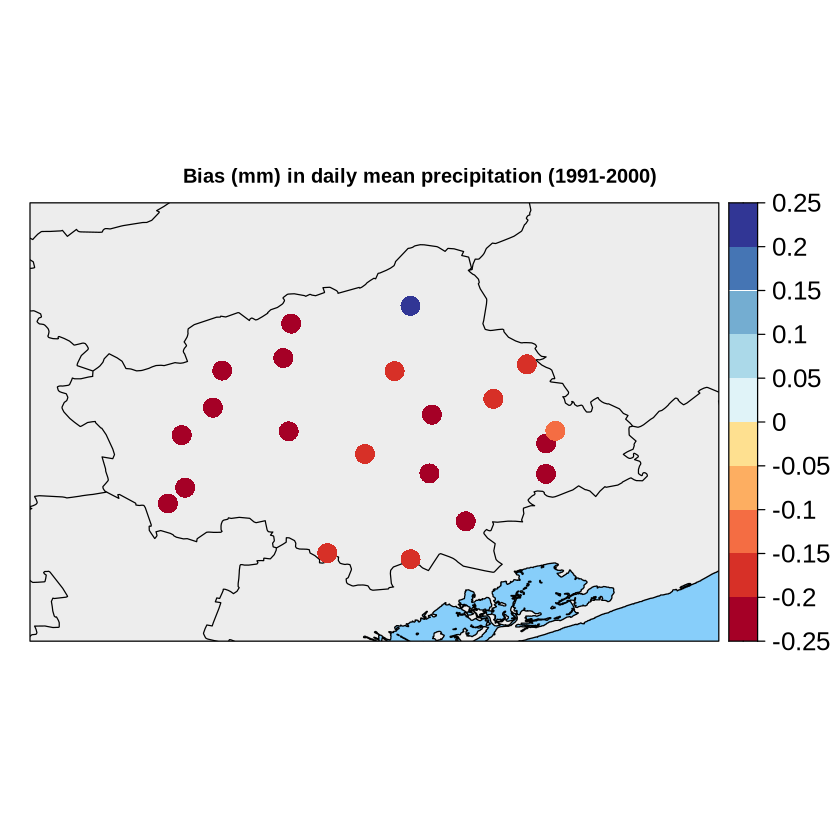

In [16]:
# bias and correlation
bias <- gridArithmetics(climatology(pr_pred), climatology(pr_obs), operator = "-")
bk <- seq(-0.25, 0.25, 0.05)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(11,"RdYlBu"))
cmap <- cols(cmap.nbins)
spatialPlot(bias, cex=2, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk),
    cuts = bk,  main = list(label="Bias (mm) in daily mean precipitation (1991-2000)", cex=1),
    par.strip.text = list(cex = 1),
    colorkey = list(right = list( fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

We can focus on accumulated precipitation in one month and calculate the  relative bias:

In [17]:
pr_pred_jul <- subsetGrid(pr_pred, season=7)
pr_obs_jul <- subsetGrid(pr_obs, season=7)

In [18]:
pr_pred_jul_agg <- aggregateGrid(pr_pred_jul, aggr.m = list(FUN = sum, na.rm = TRUE))
pr_obs_jul_agg <- aggregateGrid(pr_obs_jul, aggr.m = list(FUN = sum, na.rm = TRUE))


[2026-02-24 16:51:43.459201] Performing monthly aggregation...

[2026-02-24 16:51:43.460708] Done.

[2026-02-24 16:51:43.462471] Performing monthly aggregation...

[2026-02-24 16:51:43.463781] Done.



[2026-02-24 16:51:43.479318] - Computing climatology...

[2026-02-24 16:51:43.480385] - Done.

[2026-02-24 16:51:43.482796] - Computing climatology...

[2026-02-24 16:51:43.483988] - Done.

[2026-02-24 16:51:43.486741] - Computing climatology...

[2026-02-24 16:51:43.487849] - Done.



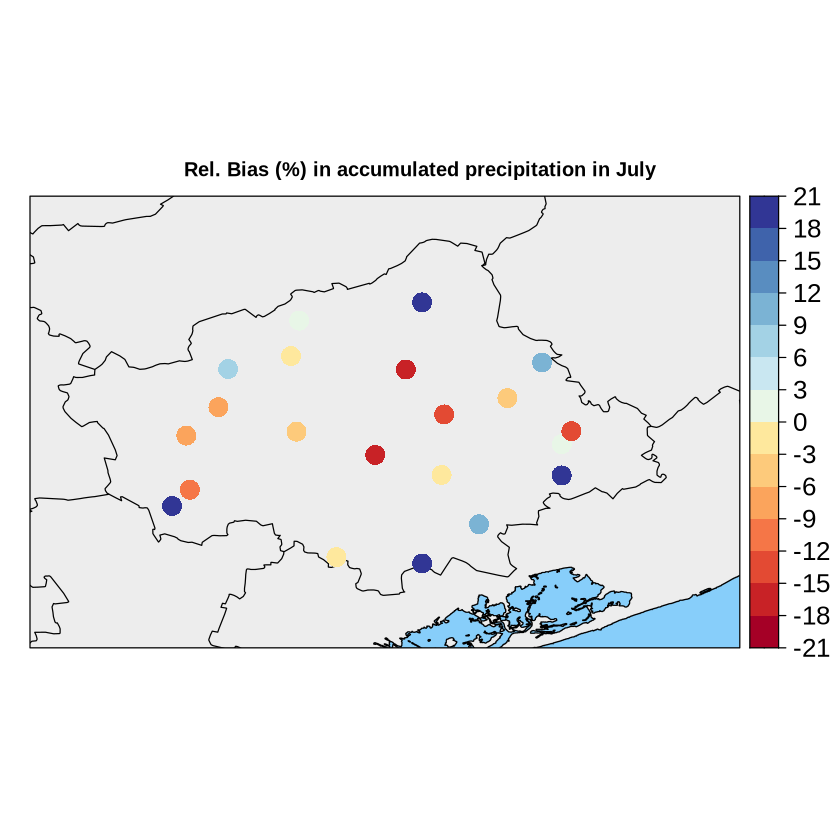

In [19]:
bias_rel <- gridArithmetics(climatology(pr_pred_jul_agg), climatology(pr_obs_jul_agg), climatology(pr_obs_jul_agg), 100, operator=c("-", "/", "*"))
bk <- seq(-21, 21, 3)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(11,"RdYlBu"))
cmap <- cols(cmap.nbins)
spatialPlot(bias_rel, cex=2, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk),
    cuts = bk,  main = list(label="Rel. Bias (%) in accumulated precipitation in July", cex=1),
    par.strip.text = list(cex = 1),
    colorkey = list(right = list( fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))
  

We can also evaluate the temporal sequence deriving temporal correlation:

In [20]:
correlation <- bias # only to create a C4R object to fill with correlation values
for(i in 1:dim(pr_pred$Data)[2]){
    corr.aux <- cor(pr_pred$Data[,i], pr_obs$Data[,i], use="complete.obs", method = "spearman")
    correlation$Data[,i] <- corr.aux
    rm(corr.aux)
}

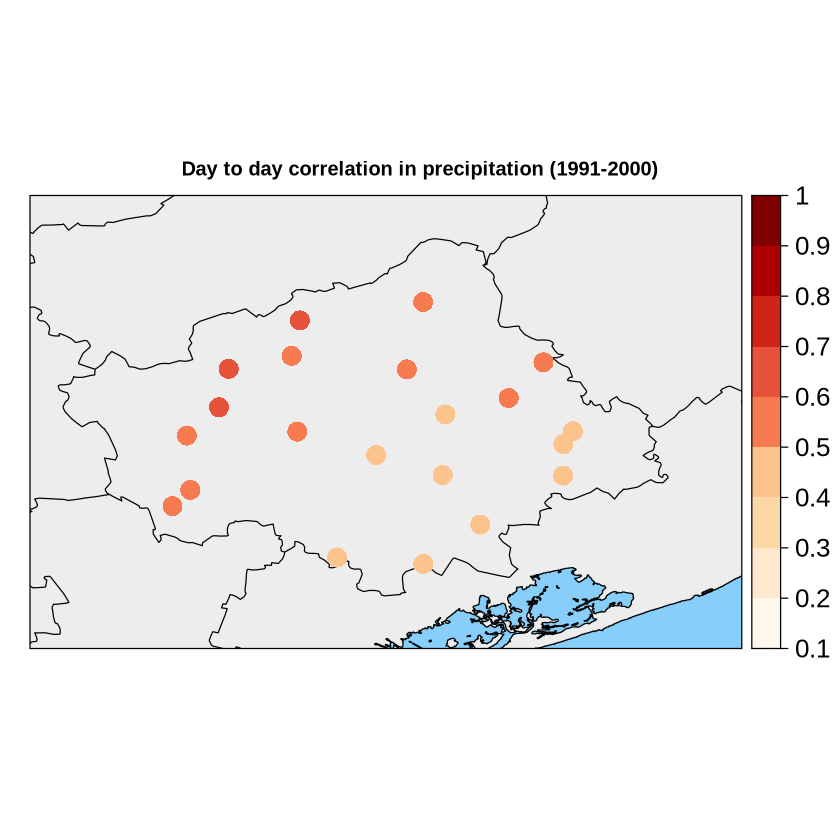

In [21]:
bk <- seq(0.1,1, 0.1)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(9,"OrRd"))
cmap <- cols(cmap.nbins)
spatialPlot(correlation, cex=2, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")),
                        col.regions = cmap, set.min = min(bk), set.max = max(bk),
                        cuts = bk, main = list(label="Day to day correlation in precipitation (1991-2000)", cex=1),
                        par.strip.text = list(cex = 1),
                        colorkey = list(right = list( fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

### Example for daily maximum temperature

In [22]:
tasmax_pred <- downscaleCV(x, tasmax_obs, folds = nfold, sampling.strategy = "kfold.random",
                        scaleGrid.args = list(type = "standardize"),
                        method = "GLM", family = gaussian(link = "identity"),
                        prepareData.args = list("spatial.predictors" = list(which.combine = 
                        getVarNames(x), v.exp = 0.95)))

fold: 1 --> calculating...

[2026-02-24 16:51:44.377055] - Scaling ...

[2026-02-24 16:51:44.588594] - Done

[2026-02-24 16:51:44.589642] - Scaling ...

[2026-02-24 16:51:44.712435] - Done

[2026-02-24 16:51:44.793627] Performing PC analysis on 14 variables plus a combination ...

[2026-02-24 16:51:44.880836] Done.

fold: 2 --> calculating...

[2026-02-24 16:51:45.048332] - Scaling ...

[2026-02-24 16:51:45.103478] - Done

[2026-02-24 16:51:45.104549] - Scaling ...

[2026-02-24 16:51:45.236234] - Done

[2026-02-24 16:51:45.323378] Performing PC analysis on 14 variables plus a combination ...

[2026-02-24 16:51:45.412319] Done.

fold: 3 --> calculating...

[2026-02-24 16:51:45.568394] - Scaling ...

[2026-02-24 16:51:45.72644] - Done

[2026-02-24 16:51:45.727491] - Scaling ...

[2026-02-24 16:51:45.852781] - Done

[2026-02-24 16:51:45.935123] Performing PC analysis on 14 variables plus a combination ...

[2026-02-24 16:51:46.017982] Done.

fold: 4 --> calculating...

[2026-02-24 16:51:4

Evaluate predictions:

In [23]:
tasmax_pred_jul <- subsetGrid(tasmax_pred, season=7)
tasmax_obs_jul <- subsetGrid(tasmax_obs, season=7)

[2026-02-24 16:51:47.225235] - Computing climatology...

[2026-02-24 16:51:47.226235] - Done.

[2026-02-24 16:51:47.228067] - Computing climatology...

[2026-02-24 16:51:47.229015] - Done.



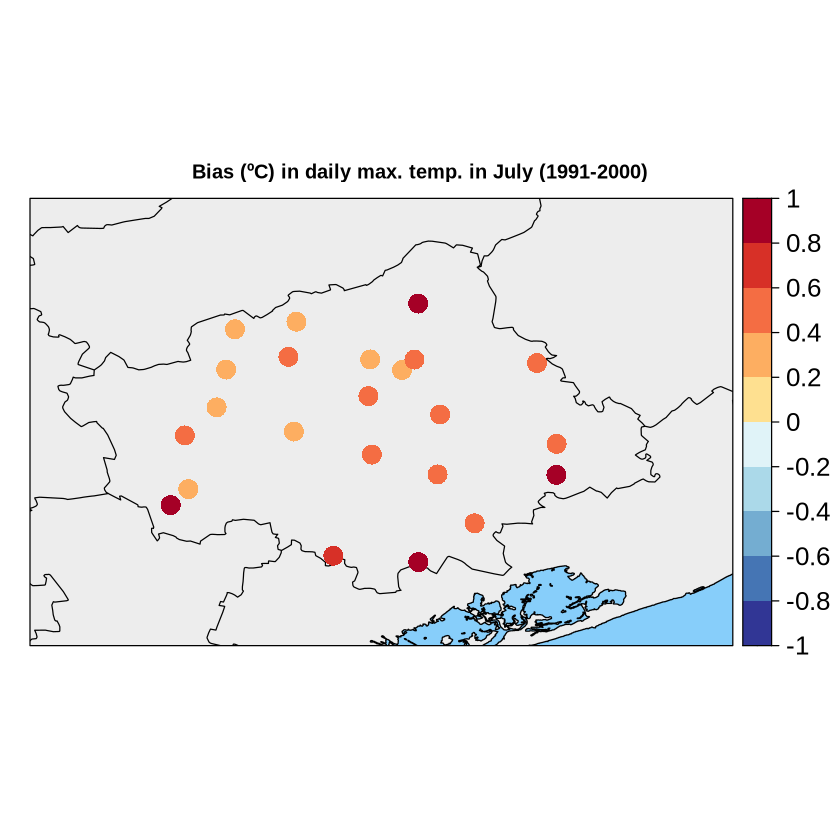

In [24]:
bias <- gridArithmetics(climatology(tasmax_pred_jul), climatology(tasmax_obs_jul), operator = "-")
bk <- seq(-1, 1, 0.2) 
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(11,"RdYlBu"))
cmap <- rev(cols(cmap.nbins))
spatialPlot(bias, cex=2, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk), 
    cuts = bk,  main = list(label="Bias (ºC) in daily max. temp. in July (1991-2000)", cex=1),
    par.strip.text = list(cex = 1),
    colorkey = list(right = list( fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

In [25]:
correlation <- bias # only to create a C4R object to fill with correlation values
for(i in 1:dim(tasmax_pred$Data)[2]){
    corr.aux <- cor(tasmax_pred$Data[,i], tasmax_obs$Data[,i], use="complete.obs", method = "pearson")
    correlation$Data[,i] <- corr.aux
    rm(corr.aux)
}

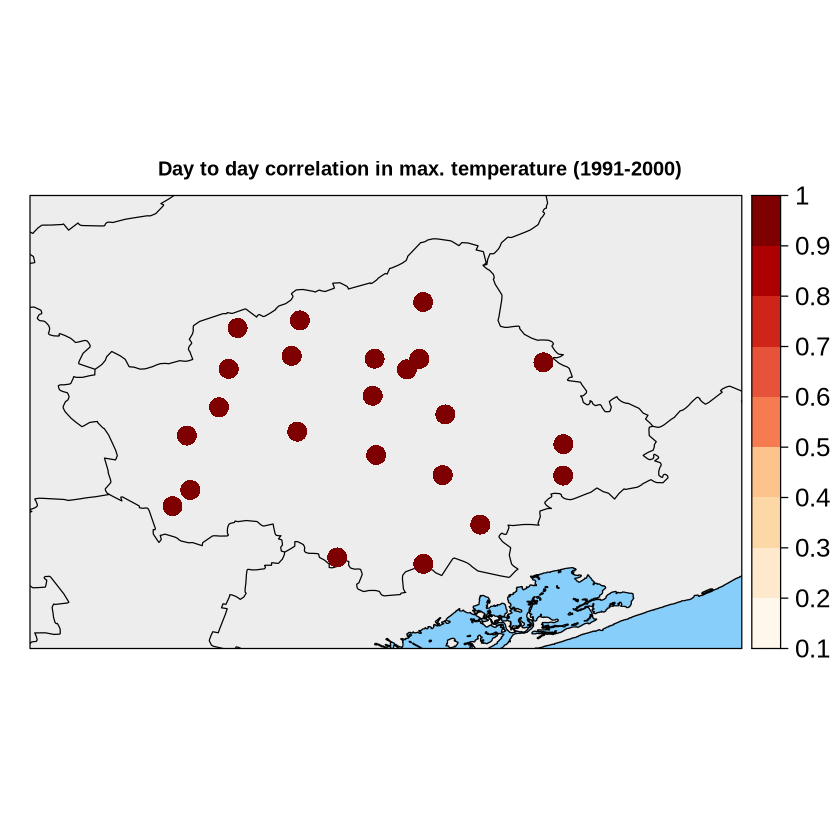

In [26]:
bk <- seq(0.1,1, 0.1)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(9,"OrRd"))
cmap <- cols(cmap.nbins)
spatialPlot(correlation, cex=2, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")),
                        col.regions = cmap, set.min = min(bk), set.max = max(bk),
                        cuts = bk, main = list(label="Day to day correlation in max. temperature (1991-2000)", cex=1),
                        par.strip.text = list(cex = 1),
                        colorkey = list(right = list( fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

### Session Information

In [27]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 24.04.4 LTS

Matrix products: default
BLAS/LAPACK: /home/ana/micromamba/envs/prosecco/lib/libopenblasp-r0.3.30.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=es_ES.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=es_ES.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=es_ES.UTF-8          LC_NAME=es_ES.UTF-8          
 [9] LC_ADDRESS=es_ES.UTF-8        LC_TELEPHONE=es_ES.UTF-8     
[11] LC_MEASUREMENT=es_ES.UTF-8    LC_IDENTIFICATION=es_ES.UTF-8

time zone: Europe/Madrid
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] RColorBrewer_1.1-3  sp_2.2-0            lattice_0.22-7     
 [4] visualizeR_1.6.4    downscaleR_3.3.4    transformeR_2.2.2  
 [7] loadeR_1.8.4        climate4R.UDG_0.2.6 loadeR.java_1.